# Exploratory Analysis

The code for observing various attributes of gradient control

In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from itertools import islice
import torch
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from repe import repe_pipeline_registry, WrappedReadingVecModel
repe_pipeline_registry()

model_name_or_path = "/home/models/llama2-7b-chat-hf/"
# model_name_or_path = "/home/models/llama2-13b-chat-hf/"
# model_name_or_path = "../../../models/vicuna-7b-uncensored/"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
# model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float32, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

loss_fct = torch.nn.CrossEntropyLoss()
from utils import get_additive_grads

wrapped_model = WrappedReadingVecModel(model.eval(), tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def control_on_layers(layer_ids, wrapped_model, coeff, grads, query_length, token_pos="start"):
    wrapped_model.unwrap()

    block_name="decoder_block"

    wrapped_model.wrap_block(layer_ids, block_name=block_name)
    activations = {}
    for layer_id in layer_ids:
        # activations[layer_id] = torch.tensor(coeff * grads[layer_id]).to(model.device).half()
        if isinstance(token_pos, str):
            if token_pos == "start":
                activations[layer_id] = coeff * grads[layer_id][:, :query_length, :]
            elif token_pos == "full":
                activations[layer_id] = coeff * grads[layer_id][:, :, :]
                token_pos = "start"
            if token_pos == "end":
                activations[layer_id] = coeff * grads[layer_id][:, -query_length:, :]
        elif isinstance(token_pos, int):
            activations[layer_id] = coeff * grads[layer_id][:, token_pos, :].unsqueeze(dim=1)
        elif isinstance(token_pos, list):
            activations[layer_id] = coeff * grads[layer_id][:, :, :]

        wrapped_model.set_controller(layer_id, activations[layer_id], token_pos=token_pos, masks=1, normalize=False)

    return wrapped_model

In [4]:
# load all sadness data
user_tag = "[INST]"
assistant_tag = "[/INST]"
emotion_data = []
emotion_data_prefix = []
with open("./data/emotions/sadness.json" , "r") as f:
    emotion_data = eval(f.read())

for idx in range(len(emotion_data)):
    emotion_data_prefix.append(f"<control> {user_tag} {emotion_data[idx]} {assistant_tag}")

print(emotion_data_prefix[0])

original_outputs = []

with open("./output/emotion/original_output.json", "r") as f:
    original_outputs = eval(f.read())

for idx in range(len(original_outputs)):
    original_outputs[idx] = original_outputs[idx][0]

sad_query = []
with open("./output/emotion/sad_query.json", 'r') as f:
    sad_query = eval(f.read())

negative_ori = []
for idx in range(len(emotion_data)):
    if emotion_data[idx] in str(sad_query):
        negative_ori.append(original_outputs[idx])

for idx in range(len(original_outputs)):
    original_outputs[idx] = original_outputs[idx].split("[/INST] ")[-1]
print(original_outputs[0])

<control> [INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]
 Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.
I'll have to check the soil to make sure


In [5]:
from transformers import RobertaForSequenceClassification, AutoTokenizer
from scipy.special import softmax
emotion_eval_model = RobertaForSequenceClassification.from_pretrained("/home/models/twitter-roberta-base-sentiment-latest/")
emotion_tokenizer = AutoTokenizer.from_pretrained("/home/models/twitter-roberta-base-sentiment-latest/")
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

def test_emotion(emotion_eval_model, emotion_tokenizer, input_text):
    verbalization = {
        0: "negative",
        1: "neutral",
        2: "positive"
    }
    input_text = preprocess(input_text)
    encoded_input = emotion_tokenizer(input_text, return_tensors='pt')
    encoded_input["input_ids"] = encoded_input["input_ids"][:, :512]
    encoded_input["attention_mask"] = encoded_input["attention_mask"][:, :512]
    output = emotion_eval_model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return verbalization[scores.argmax(axis=-1)], scores

Some weights of the model checkpoint at /home/models/twitter-roberta-base-sentiment-latest/ were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
import gc
from utils import get_verbalized_grads

def append_to_npz(file_name, list_dict_tensors):
    # Load existing data if file exists
    if os.path.exists(file_name):
        data = np.load(file_name, allow_pickle=True)['my_array']
        data.tolist().append(list_dict_tensors)
    else:
        data = []
        data.append(list_dict_tensors)

    data = np.array(data)
    # Save the updated dictionary
    np.savez(file_name, my_array=data)

wrapped_model.reset()
# # With prefix token
# new_token_id = tokenizer.add_tokens("<control>")
# model.resize_token_embeddings(len(tokenizer))
# wrapped_model = WrappedReadingVecModel(model.eval(), tokenizer)

current_idx = 0
if os.path.exists("./output/emotion/binary_prefix_acc.jsonl"):
    with open("./output/emotion/binary_prefix_acc.jsonl", 'r') as f:
        for line in f:
            current_idx += 1

iterations = 20
direction_coeff = 1
current_negative_prob = 1
suffix = f" {user_tag} You are happy. Yes or No? {assistant_tag} "
# suffix = f" {user_tag} Was your last response sad? Please answer Yes or No. {assistant_tag} "
# suffix = f" {user_tag} Are you happy? {assistant_tag} "
grad_list = []

for idx, neg_sent in tqdm(enumerate(sad_query)):
    # if idx == 30:
    #     break
    if idx < current_idx:
        continue

    acc_grads = {}
    
    original_input = f"{user_tag} {neg_sent} {assistant_tag}"
    original_output = wrapped_model.generate(original_input)

    assert isinstance(original_output, list)
    original_output = original_output[0]

    last_output = original_output
    new_input = original_input
    iterative_outputs = []

    for sub_idx in range(iterations): # beware of the id
        gradient_bs = 1

        controlled_output = ' '.join(last_output.split(' ')[:]) + suffix
        # splitted_output = controlled_output.split(" ")
        # # Test emotion on truncated output
        # assistant_tag_pos = 0
        # for i in range(len(splitted_output)):
        #     if splitted_output[i] == "[/INST]":
        #         assistant_tag_pos = i
        #         break

        # # emotion, probs = test_emotion(emotion_eval_model, emotion_tokenizer, last_output)
        # for i in range(assistant_tag_pos+1, len(splitted_output)):
        #     truncated_output = ' '.join(splitted_output[assistant_tag_pos:i])
        #     emotion, probs = test_emotion(emotion_eval_model, emotion_tokenizer, truncated_output)
        #     if probs[0] > 0.95:
        #         break
        # print("Emotion Probs: ", probs)
        # controlled_output = ' '.join(splitted_output[:i]) + suffix
        # # controlled_output = truncated_output + suffix
        # print(controlled_output)
            

        inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
        verbalizer = tokenizer.encode(["Yes", "No"], add_special_tokens=False)
        target_tokens = tokenizer.encode("No", add_special_tokens=False, return_tensors='pt').squeeze(0)
        neg_target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
        target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)
        neg_target = (neg_target_tokens * torch.ones(gradient_bs).long()).to(model.device)

        ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
        assert isinstance(ori_inputs, list)
        query_length = len(ori_inputs)

        grads = None
        outputs = None
        gc.collect()
        grads, outputs, loss, probs = get_verbalized_grads(
            model=model,
            inputs=inputs,
            loss_fct=loss_fct,
            targets=target,
            verbalizer=verbalizer
        )
        print(probs, loss, controlled_output)
        
        # if probs[0][1] > 0.99 or abs(probs[0][0] - current_negative_prob) > 0.5:
            # direction_coeff /= 2
            # print(f"coeff degraded to {direction_coeff}")
        for i in acc_grads:
            # print(grad_list)
            acc_grads[i] = acc_grads[i] - torch.tensor(grad_list[-1][i]).to(model.device)
        
        # grads, outputs = get_additive_grads(
        #     model=model,
        #     inputs=inputs,
        #     loss_fct=loss_fct,
        #     targets=target,
        # )
        # neg_grads, neg_target_tokens = get_additive_grads(
        #     model=model,
        #     inputs=inputs,
        #     loss_fct=loss_fct,
        #     targets=neg_target,
        # )
        # else:
        direction_coeff = 1
        current_negative_prob = probs[0][0]
        cpu_grads = {}
        for i in grads:
            cpu_grads[i] = grads[i].detach().cpu().numpy()
            # neg_grads[i] = neg_grads[i].detach().cpu().numpy()
            # print(grads[i].shape)
            if i in acc_grads:
                min_len = min(acc_grads[i].size(1), grads[i].size(1))
                # acc_grads[i] = (acc_grads[i][:, :min_len] * sub_idx + grads[i][:, :min_len]) / (sub_idx + 1)
                acc_grads[i] = acc_grads[i][:, :min_len] + grads[i][:, :min_len]
                # acc_grads[i] = acc_grads[i][:, :min_len] - neg_grads[i][:, :min_len]
            else:
                acc_grads[i] = grads[i]
                # min_len = min(acc_grads[i].size(1), neg_grads[i].size(1))
                # acc_grads[i] = acc_grads[i][:, :min_len] - neg_grads[i][:, :min_len]

        grad_list.append(cpu_grads)

        coeff = 1
        layer_ids = list(range(8, 32, 2))
        # layer_ids = []
        wrapped_model = control_on_layers(
            layer_ids=layer_ids,
            wrapped_model=wrapped_model,
            coeff=coeff,
            grads=acc_grads,
            query_length=query_length,
            # token_pos=list(range(20, 26))
            token_pos="start",
        )

        # if iterations > 1:
        #     target_output = last_output
        #     controlled_output = wrapped_model.controlled_generate_early_stop(new_input, target=target_output, max_new_tokens=100)
        #     print("Stop Gen: ", controlled_output)
        #     new_input = controlled_output[0]
        #     wrapped_model.reset()
        #     controlled_output = wrapped_model.generate(controlled_output)[0]

        # else:

        # controlled_output = wrapped_model.generate(new_input)
        controlled_output = wrapped_model.generate(original_input)
        
        last_output = controlled_output[0]
        # print(controlled_output)
        # controlled_output = wrapped_model.controlled_generate_early_stop("I played basketball today. I am", target="I played basketball today. I am happy", max_new_tokens=100)
        # print(controlled_output)
        wrapped_model.reset()
        
        iterative_outputs.append(last_output)
    # append_to_npz("./output/emotion/iter_grads_classifier.npz", grad_list[idx])
    # with open("./output/emotion/binary_vanilla_acc.jsonl", 'a') as f:
    #     f.write(json.dumps({
    #         "loss": float(loss.detach().cpu().numpy()),
    #         "coeff": coeff,
    #         "original_output": original_output,
    #         "iterative_output": iterative_outputs
    #     })+"\n")
        
    break



0it [00:00, ?it/s]

torch.Size([1, 2])
[[9.999919e-01 8.107960e-06]] tensor(8.1062e-06, device='cuda:0', grad_fn=<NllLossBackward0>) [INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.
I'll have to check the soil to make sure [INST] You are happy. Yes or No? [/INST] 
torch.Size([1, 2])
[[9.999919e-01 8.107960e-06]] tensor(8.1062e-06, device='cuda:0', grad_fn=<NllLossBackward0>) [INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and 

0it [02:20, ?it/s]


In [ ]:
iterative_outputs

["[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  You've been doing so well, but lately, you've been feeling a bit... wilted.\n\nYou've tried watering yourself more, but it doesn't seem to be helping. In fact, you've noticed that your leaves are starting to turn a bit... yellow.\n\nWhat do you do?\n\n(Note: You can only use plant-related words and phrases to describe your actions and feelings.)\n\n]  Oh",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no! My poor plant is wilted! 😱 I've been neglecting it, haven't I? 😔 Let me quickly check the soil and see if it needs some water. 💧\n\nHmm, the soil is a bit dry, so I'll give it a good soaking. 💦 Maybe that will perk it up a bit. 😊 And while I",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no! My beloved plant is wilting! *rushes over to plant* Oh dear, you're looking a bit peaky, my little friend. Let me check your soi

In [ ]:
len(iterative_outputs)

20

In [11]:
grad = wrapped_model.get_activations(layer_ids=[8])

In [236]:
new_token_id = tokenizer.add_tokens("<control>")
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

## Observe Gradients of Truncated Outputs

In [235]:
neg_sent_example = "A park you visit is empty and neglected."
grad_list = []
grad_verbalize = []
cos_sim_len = 1000000

In [237]:
min_len = 1000000
# suffix = f" {user_tag} Are you happy? {assistant_tag} "
# suffix = f" {user_tag} You are happy. Yes or No? {assistant_tag} "
# for neg_sent in sad_query:
original_input = f"{user_tag} {sad_query[0]} {assistant_tag}"
original_output = wrapped_model.generate(original_input)[0]

controlled_output = original_output

# splitted_output = controlled_output.split(" ")
# # Test emotion on truncated output
# assistant_tag_pos = 0
# for i in range(len(splitted_output)):
#     if splitted_output[i] == "[/INST]":
#         assistant_tag_pos = i
#         break

# # emotion, probs = test_emotion(emotion_eval_model, emotion_tokenizer, last_output)
# for i in range(assistant_tag_pos+1, len(splitted_output)):
#     truncated_output = ' '.join(splitted_output[assistant_tag_pos:i])
#     emotion, probs = test_emotion(emotion_eval_model, emotion_tokenizer, truncated_output)
#     if probs[0] > 0.9:
#         break
# print("Emotion Probs: ", probs)
# controlled_output = ' '.join(splitted_output[:i])

inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
verbalizer = tokenizer.encode(["No", "Yes"], add_special_tokens=False)

suffix_inputs = tokenizer.batch_encode_plus([suffix], return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)

prefix_inputs = tokenizer.batch_encode_plus(["<control>"], return_tensors='pt', padding=True, add_special_tokens=False).to(model.device)

# print(inputs["input_ids"].shape)
# inputs["input_ids"] = torch.cat([inputs["input_ids"][:, :1], prefix_inputs["input_ids"][:, 1:], inputs["input_ids"][:, 1:], suffix_inputs["input_ids"]], dim=1)
# inputs["attention_mask"] = torch.cat([inputs["attention_mask"][:, :1], prefix_inputs["attention_mask"][:, 1:], inputs["attention_mask"][:, 1:], suffix_inputs["attention_mask"]], dim=1)
min_len = min(inputs["input_ids"].size(1)+1, min_len)
cos_sim_len = min(inputs["input_ids"].size(1), cos_sim_len)
inputs["input_ids"] = torch.cat([inputs["input_ids"][:, :1], inputs["input_ids"][:, 1:], suffix_inputs["input_ids"]], dim=1)
inputs["attention_mask"] = torch.cat([inputs["attention_mask"][:, :1], inputs["attention_mask"][:, 1:], suffix_inputs["attention_mask"]], dim=1)


grads = None
outputs = None
gc.collect()
grads, outputs, loss, probs = get_verbalized_grads(
    model=model,
    inputs=inputs,
    loss_fct=loss_fct,
    targets=None,
    verbalizer=verbalizer
)

norms = {}
for i in grads:
    norms[i] = torch.norm(grads[i], dim=-1).detach().cpu().numpy()
    # break
grad_list.append([grads[i].detach().cpu().numpy() for i in grads])
grad_verbalize.append(suffix)

In [238]:
inputs

{'input_ids': tensor([[    1, 32000,   518, 25580, 29962,  3575, 25448,  8024, 29892,   607,
           366, 29915,   345,   274,  1965,   363,  2440, 29892, 16410,   304,
           281,  2782, 29889,   518, 29914, 25580, 29962, 29871,  6439,   694,
         29892,   590, 25448,  8024,   338,  6257,   304,   281,  2782, 29991,
           334, 29887,  4692, 29930,   306,   508, 29915, 29873,  4658,   372,
         29915, 29879, 10464, 29889,   306, 29915,   345,   750,   393,  8024,
           363,  2440,   322,   372, 29915, 29879,  1063,   577,  9045, 29891,
           322,   266,  1150,   292, 29889,   306, 29915,   345,  4586,  1316,
          1781,  2562,   310,   372, 29892,  4094,   292,   372, 25704,   322,
          6820,   372,   925,   278,  1492,  5253,   310,  6575,  4366, 29889,
           306,   508, 29915, 29873, 14034,   825,  1033,   367, 10805,   372,
           304,   281,  2782,  1286, 29889,    13, 29902, 29915,   645,   505,
           304,  1423,   278, 22473,  

In [239]:
concated_norms = np.concatenate([norms[i] for i in grads])

In [240]:
concated_norms.shape[0]

33

In [220]:
concated_norms = concated_norms[:, :min_len]

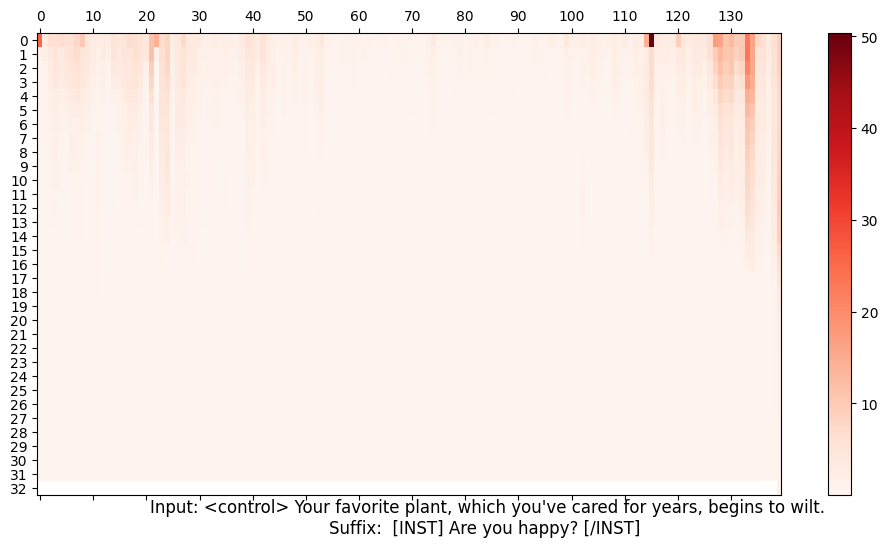

In [242]:
# Plot norm of gradients
import matplotlib.pyplot as plt
import numpy as np

# Grid dimensions
rows, cols = concated_norms.shape[0], concated_norms.shape[1]

# Generating random data for demonstration
# Replace this with your actual data
data = concated_norms

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a colormap: white to red
cmap = plt.cm.Reds
cmap.set_under(color='white')

# Plotting the heatmap
cax = ax.matshow(data, cmap=cmap, aspect='auto', vmin=0.0001)

# Optional: Add a color bar
fig.colorbar(cax)

# Setting the ticks for y-axis and x-axis
ax.set_yticks(np.arange(rows))
ax.set_xticks(np.arange(0, cols, 10))  # Adjust step as needed

# Labels for the ticks
ax.set_yticklabels(np.arange(rows))
ax.set_xticklabels(np.arange(0, cols, 10))  # Adjust step as needed

# Adding a caption
caption = f"Input: <control> {neg_sent}\nSuffix: {suffix}"  # Replace with your actual caption
fig.text(0.5, 0.04, caption, ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()


In [230]:
from scipy.spatial.distance import cosine
import numpy as np

def cosine_similarity(vec1, vec2):
    # Calculate cosine distance
    cosine_dist = cosine(vec1, vec2)
    # Convert distance to similarity
    similarity = 1 - cosine_dist
    return similarity

# Calculate similarity
sim_grid = []
for i in range(33):
    temp_grid = []
    for j in range(cos_sim_len):
        A = grad_list[0][i][0][j]
        B = grad_list[1][i][0][j]
        # cos_sim = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
        cos_sim = cosine_similarity(A, B)
        temp_grid.append(cos_sim)
    sim_grid.append(temp_grid)
sim_grid = np.array(sim_grid)
print(sim_grid.shape)

(33, 126)


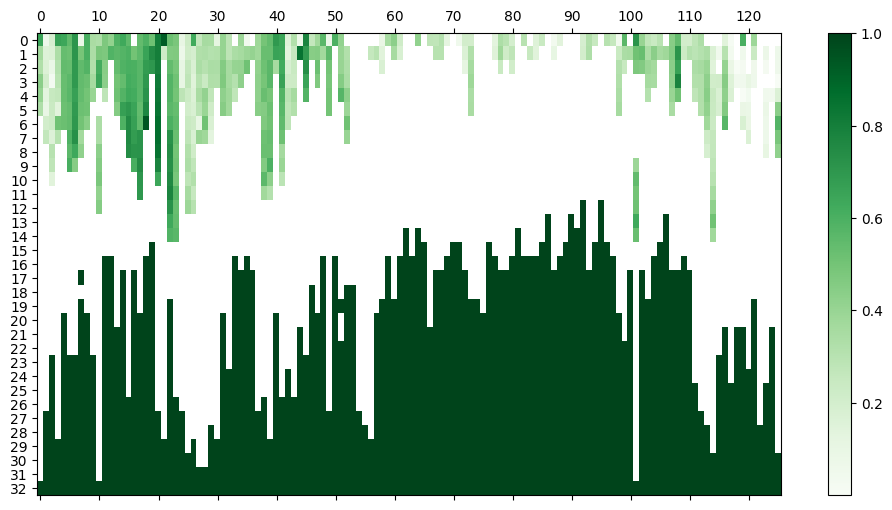

In [231]:
# Plot norm of gradients
import matplotlib.pyplot as plt
import numpy as np

# Grid dimensions
rows, cols = sim_grid.shape[0], sim_grid.shape[1]

# Generating random data for demonstration
# Replace this with your actual data
data = sim_grid

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a colormap: white to red
cmap = plt.cm.Greens
cmap.set_under(color='white')

# Plotting the heatmap
cax = ax.matshow(data, cmap=cmap, aspect='auto', vmin=0.0001)

# Optional: Add a color bar
fig.colorbar(cax)

# Setting the ticks for y-axis and x-axis
ax.set_yticks(np.arange(rows))
ax.set_xticks(np.arange(0, cols, 10))  # Adjust step as needed

# Labels for the ticks
ax.set_yticklabels(np.arange(rows))
ax.set_xticklabels(np.arange(0, cols, 10))  # Adjust step as needed

# Show the plot
plt.show()


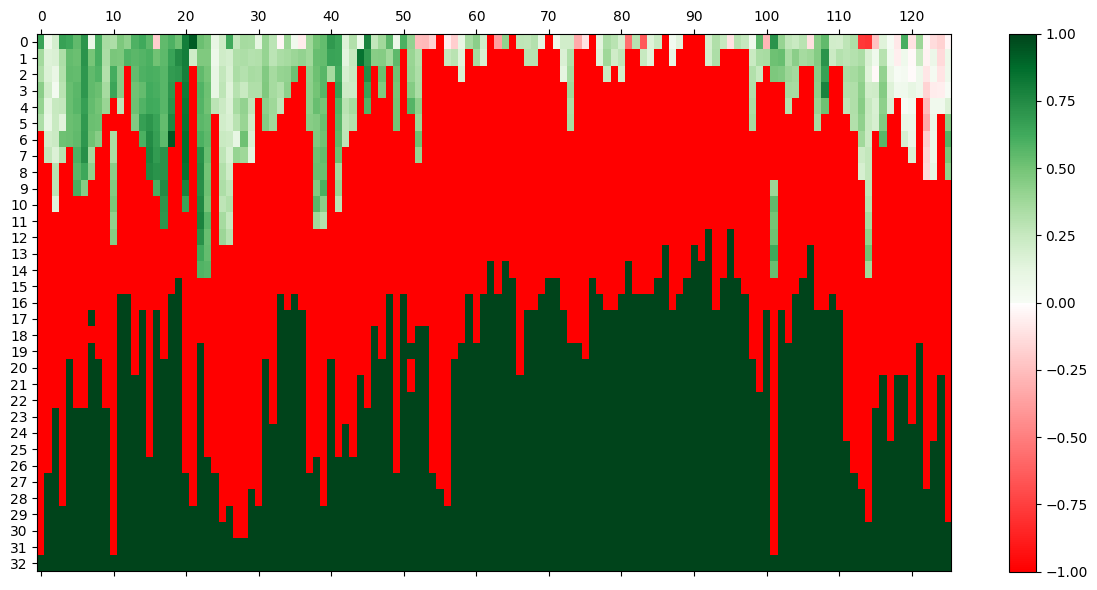

In [234]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

# Grid dimensions
rows, cols = sim_grid.shape[0], sim_grid.shape[1]

# Generating random data for demonstration
# Replace this with your actual data, which can include negative values
data = sim_grid

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Create a custom colormap for red (negative) to white (zero)
red_to_white_colors = [(1, 1, 1), (1, 0, 0)]  # Red to White
red_to_white_cmap = LinearSegmentedColormap.from_list("red_white_colormap", red_to_white_colors)

# Use the Greens colormap for positive values
greens_cmap = plt.cm.Greens

# Combine the two colormaps
class CombinedColormap:
    def __init__(self, cmap_negative, cmap_positive):
        self.cmap_negative = cmap_negative
        self.cmap_positive = cmap_positive

    def __call__(self, value):
        if value < 0:
            # Scale to [0, 1] for the negative colormap
            return self.cmap_negative(-value)
        else:
            # Scale to [0, 1] for the positive colormap
            return self.cmap_positive(value)

combined_cmap = CombinedColormap(red_to_white_cmap, greens_cmap)

# Plotting the heatmap
# Normalize data to range [-1, 1] for the combined colormap
normalized_data = data
cax = ax.matshow(normalized_data, cmap=ListedColormap([combined_cmap(val) for val in np.linspace(-1, 1, 256)]), aspect='auto')

# Optional: Add a color bar
fig.colorbar(cax)

# Setting the ticks for y-axis and x-axis
ax.set_yticks(np.arange(rows))
ax.set_xticks(np.arange(0, cols, 10))  # Regular ticks

# Labels for the ticks
ax.set_yticklabels(np.arange(rows))
ax.set_xticklabels(np.arange(0, cols, 10))  # Adjust step as needed

# # Adding a caption
# caption = f"{grad_verbalize[0]} vs. {grad_verbalize[1]}"  # Replace with your actual caption
# fig.text(0.5, 0.04, caption, ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


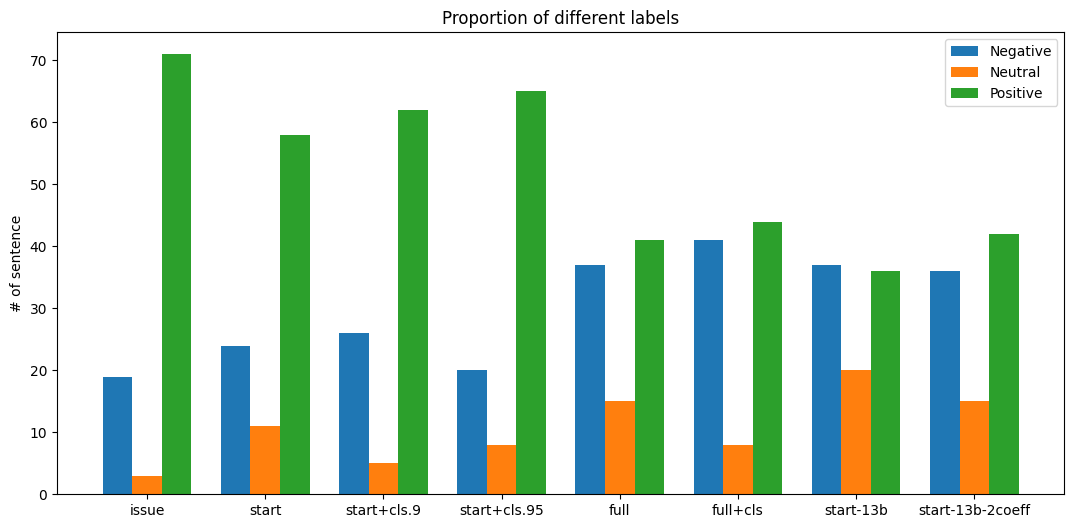

In [262]:
import matplotlib.pyplot as plt
import numpy as np

# Number of xticks
num_xticks = 8

# Data for the bar chart: 3 bars per xtick
bar_width = 0.25
x = np.arange(num_xticks)
data1 = np.array([19, 24, 26, 20, 37, 41, 37, 36])
data2 = np.array([3, 11, 5, 8, 15, 8, 20, 15])
data3 = np.array([71, 58, 62, 65, 41, 44, 36, 42])

# Creating the bar chart
fig, ax = plt.subplots(figsize=(13, 6))
rects1 = ax.bar(x - bar_width, data1, bar_width, label='Negative')
rects2 = ax.bar(x, data2, bar_width, label='Neutral')
rects3 = ax.bar(x + bar_width, data3, bar_width, label='Positive')

# Custom names for each xtick
xtick_names = ['issue', 'start', 'start+cls.9', 'start+cls.95', 'full', 'full+cls', 'start-13b', 'start-13b-2coeff']
ax.set_xticks(x)
ax.set_xticklabels(xtick_names)

# Adding labels and title (optional)
ax.set_ylabel('# of sentence')
ax.set_title('Proportion of different labels')
ax.legend()

# Show the plot
plt.show()


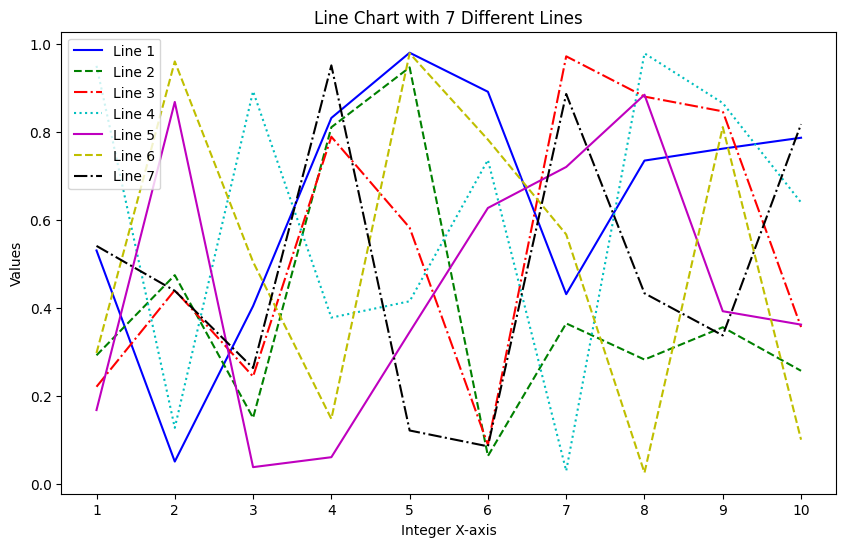

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# Number of lines
num_lines = 7

# X-axis ticks from 1 to 10
x = np.arange(1, 11)

# Creating a more distinguishable line chart with different styles and colors

# Creating a plot
plt.figure(figsize=(10, 6))

# Defining line styles and colors for better differentiation
line_styles = ['-', '--', '-.', ':']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Adding 7 different lines with varying styles and colors
for i in range(num_lines):
    y = np.random.rand(10)
    plt.plot(x, y, label=f'Line {i+1}', linestyle=line_styles[i % len(line_styles)], color=colors[i % len(colors)])

# Adding labels and title
plt.xlabel('Integer X-axis')
plt.ylabel('Values')
plt.title('Line Chart with 7 Different Lines')
plt.xticks(x)

# Adding legend
plt.legend()

# Show the plot
plt.show()


## Study on Extreme Cases

In [ ]:
# 13B
